In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = Path("data/synthetic_loan_default_data_clean.csv")
MODEL_PATH_rf = Path("random_forest.pkl")
MODEL_PATH_lin = Path("linearReg.pkl")

In [4]:
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.lower()

In [5]:
df

,loan_amount,interest_rate,tenure_months,credit_score,income,employment_type,debt_to_income_ratio,collateral_value,late_payments,missed_emi_count,default
0,171958,12.67,36,878,191020,Contractual,0.93,798385,0,1,No
1,721155,15.23,36,364,80133,Salaried,0.60,630698,0,1,Yes
2,181932,17.34,24,387,129444,Self-Employed,1.03,1698019,3,1,Yes
3,1464414,16.20,24,324,132603,Self-Employed,0.23,1203183,2,1,Yes
4,309178,8.97,48,848,173598,Salaried,0.38,1779472,0,1,No
...,...,...,...,...,...,...,...,...,...,...,...
995,765460,15.64,12,318,129456,Salaried,0.86,1312595,3,2,Yes
996,934574,12.47,84,367,77559,Salaried,1.07,1561023,3,2,Yes
997,1763796,9.74,48,360,79892,Salaried,0.42,495288,0,2,Yes
998,285365,13.32,60,428,85409,Salaried,0.19,1447544,2,1,Yes


In [6]:
X = df.drop(columns=['default'])
#y = df['default']
y = df['default'].map({'Yes': 1, 'No': 0})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

In [9]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [10]:
lin_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

rf_pipe = Pipeline([('pre', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=2000, random_state=42, class_weight=None))])


In [11]:
lin_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['loan_amount',
                                                   'interest_rate',
                                                   'tenure_months',
                                                   'credit_score', 'income',
                                                   'debt_to_income_ratio',
                                                   'collateral_value',
                                                   'late_payments',
                                                   'missed_emi_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['employment_type'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=2000, random_state=42))])

In [12]:
def evaluate_model(name, model, X_test, y_test):
    if name == "Linear Regression":
        preds = model.predict(X_test)
        probs = preds.clip(0, 1)  # clip between 0-1
        preds_class = (probs >= 0.5).astype(int)
    else:
        probs = model.predict_proba(X_test)[:, 1]
        preds_class = model.predict(X_test)

    print(f"\n{name} Results")
    print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))
    print("Accuracy:", round(accuracy_score(y_test, preds_class), 3))
    print(classification_report(y_test, preds_class))


In [13]:
evaluate_model("Linear Regression", lin_pipe, X_test, y_test)
evaluate_model("Random Forest", rf_pipe, X_test, y_test)


Linear Regression Results
ROC AUC: 0.981
Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        56
           1       0.96      0.93      0.95       144

    accuracy                           0.93       200
   macro avg       0.90      0.92      0.91       200
weighted avg       0.93      0.93      0.93       200


Random Forest Results
ROC AUC: 1.0
Accuracy: 0.985
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        56
           1       1.00      0.98      0.99       144

    accuracy                           0.98       200
   macro avg       0.97      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200



In [14]:
# Linear Regression: Coefficients
lin_model = lin_pipe.named_steps["model"]

lin_features = lin_pipe.named_steps["preprocess"].get_feature_names_out()

coef_df = pd.DataFrame({
    "Feature": lin_features,
    "Coefficient": lin_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\nLinear Regression Coefficients (top 10):")
print(coef_df.head(10))



Linear Regression Coefficients (top 10):
                               Feature  Coefficient
3                    num__credit_score    -0.319530
4                          num__income    -0.087581
0                     num__loan_amount     0.060560
11  cat__employment_type_Self-Employed     0.017444
9     cat__employment_type_Contractual    -0.016943
8                num__missed_emi_count     0.015553
6                num__collateral_value     0.013273
12     cat__employment_type_Unemployed    -0.012752
10       cat__employment_type_Salaried     0.012250
1                   num__interest_rate    -0.011205



Random Forest Feature Importance (top 10):
num__credit_score                0.586807
num__income                      0.116330
num__loan_amount                 0.073121
num__late_payments               0.071790
num__interest_rate               0.033479
num__collateral_value            0.033470
num__debt_to_income_ratio        0.030497
num__missed_emi_count            0.029881
num__tenure_months               0.013739
cat__employment_type_Salaried    0.003610
dtype: float64


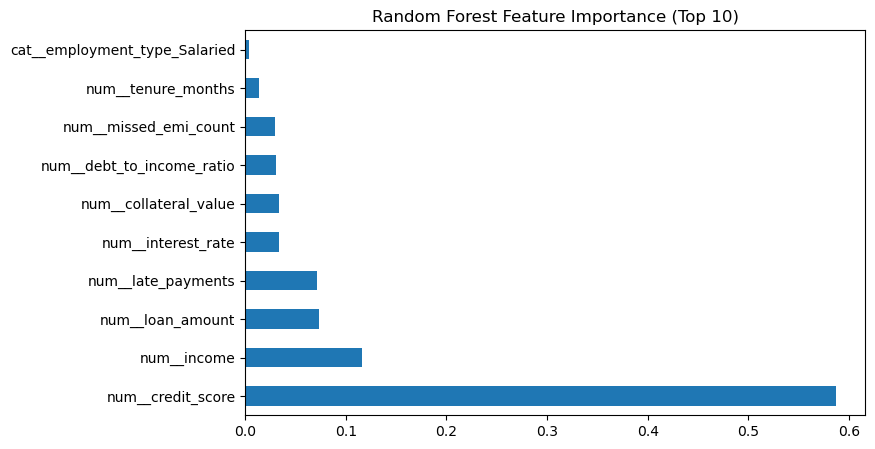

In [15]:
# 2. Random Forest feature importance
rf_model = rf_pipe.named_steps["clf"]
rf_importances = pd.Series(rf_model.feature_importances_,
                           index=lin_features).sort_values(ascending=False)

print("\nRandom Forest Feature Importance (top 10):")
print(rf_importances.head(10))

# Plot feature importance
rf_importances.head(10).plot(kind="barh", figsize=(8, 5))
plt.title("Random Forest Feature Importance (Top 10)")
plt.show()

shap_vals shape: (200, 13, 2) X_rf_test shape: (200, 13)


C:\Users\jithu\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jithu\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:758: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, w_pad=0, h_pad=0.0)


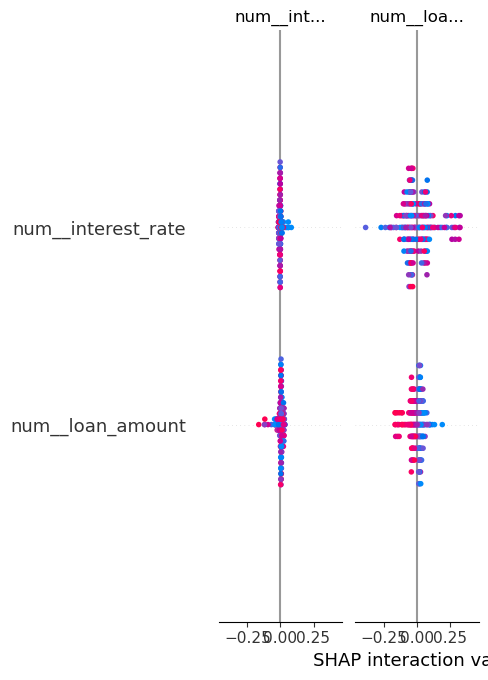

In [16]:
# --- SHAP for Random Forest ---

import shap

rf_model = rf_pipe.named_steps["clf"]
rf_preproc = rf_pipe.named_steps["pre"]

# Preprocess test data
X_rf_test = rf_preproc.transform(X_test)
rf_features = rf_preproc.get_feature_names_out()

# Use TreeExplainer in raw mode (default)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_rf_test)

# If it's a list, pick class 1 (Default = Yes)
if isinstance(shap_values, list):
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values  # already correct shape

print("shap_vals shape:", shap_vals.shape, "X_rf_test shape:", X_rf_test.shape)

# SHAP summary plot for "Default = Yes"
shap.summary_plot(shap_vals, X_rf_test, feature_names=rf_features)


In [17]:
def predict_applicant(applicant_data, models):
    df_input = pd.DataFrame([applicant_data])
    df_input.columns = df_input.columns.str.lower()
    results = {}

    for name, model in models.items():
        if name == "Linear Regression":
            score = model.predict(df_input)[0]
            prob = max(0, min(1, score))  # clip to [0,1]
        else:
            prob = model.predict_proba(df_input)[:, 1][0]

        pred = "Yes" if prob >= 0.5 else "No"

        # Risk bucketing
        if prob <= 0.30:
            bucket = "Accept"
        elif prob <= 0.60:
            bucket = "Review"
        else:
            bucket = "Reject"

        results[name] = {
            "Predicted_Default": pred,
            "Default_Probability": round(prob, 3),
            "Risk_Bucket": bucket
        }

    return results

In [18]:
new_applicant = {
    "Loan_Amount": 500000,
    "Interest_Rate": 14.5,
    "Tenure_Months": 36,
    "Credit_Score": 820,
    "Income": 45000,
    "Employment_Type": "Salaried",
    "Debt_to_Income_Ratio": 0.50,
    "Collateral_Value": 300000,
    "Late_Payments": 0,
    "Missed_EMI_Count": 3
}

models = {
    "Linear Regression": lin_pipe,
    "Random Forest": rf_pipe
}

predictions = predict_applicant(new_applicant, models)
print("\nApplicant Prediction:", predictions)


Applicant Prediction: {'Linear Regression': {'Predicted_Default': 'No', 'Default_Probability': 0.297, 'Risk_Bucket': 'Accept'}, 'Random Forest': {'Predicted_Default': 'Yes', 'Default_Probability': 0.604, 'Risk_Bucket': 'Reject'}}


In [21]:
joblib.dump(rf_pipe, MODEL_PATH_rf)
joblib.dump(lin_pipe, MODEL_PATH_lin)

['linearReg.pkl']